### Natural Language Processing, a look at distinguishing subreddit categories by analyzing the text of the comments and posts

**Matt Paterson, hello@hiremattpaterson.com**
General Assembly Data Science Immersive, July 2020

### Abstract

**HireMattPaterson.com has been (fictionally) contracted by Virgin Galactic’s marketing team to build a Natural Language Processing Model that will efficiently predict if reddit posts are being made for the SpaceX subreddit or the Boeing subreddit as a proof of concept to segmenting the targeted markets.**

We’ve created a model that predicts the silo of the post with nearly 80% accuracy (with a top score of 79.9%). To get there we tried over 2,000 different iterations on a total of 5 different classification modeling algorithms including two versions of Multinomial Naïve Bayes, Random Cut Forest, Extra Trees, and a simple Logistic Regression Classifier. We’d like to use Support Vector Machines as well as Gradient Boosting and a K-Nearest Neighbors model in our follow-up to this presentation.

If you like our proof of concept, the next iteration of our model will take in to account the trend or frequency in the comments of each user; what other subreddits these users can be found to post to (are they commenting on the Rolex and Gulfstream and Maserati or are they part of the Venture Capital and AI crowd?); and if their comments appear to be professional in nature (are they looking to someday work in aerospace or maybe they already do). These trends will help the marketing team tune their tone, choose words that are trending, and speak directly to each cohort in a narrow-cast fashion thus allowing VG to spend less money on ads and on people over time.

This notebook shows how we got there.

### Problem Statement:

Virgin Galactic wants to charge customers USD 250K per voyage to bring customers into outer space on a pleasure cruise in null G

The potential customers range from more traditional HNWI who have more conservative values, to the Nouveau Riche, and various levels of tech millionaires in between

Large teams of many Marketing Analysts and Marketing Managers are expensive

If you can keep your current headcount or only add a few you are better off, since as headcount grows, overall ROI tends to shrink (VG HC ~ 200 ppl)

### Solution:

Create a machine learning model to identify what type of interests each user has based on their social media and reddit posts

Narrowcast to each smaller cohort with the language, tone, and vocabulary that will push each to purchase the quarter-million dollar flight


## Import libraries

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import lebowski as dude

from sklearn.linear_model            import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection         import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline                import Pipeline
from sklearn.naive_bayes             import MultinomialNB
from sklearn.metrics                 import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble                import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble                import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing           import StandardScaler
from sklearn.neighbors               import KNeighborsClassifier
from sklearn.tree                    import DecisionTreeClassifier

## Read in the data. 

In the data_file_creation.ipynb found in this directory, we have already gone to the 'https://api.pushshift.io/reddit/search/' api and pulled subreddit posts and comments from SpaceX, Boeing, BlueOrigin, and VirginGalactic; four specific companies venturing into the outer space exploration business with distinct differences therein. It is the theory of this research team that each subreddit will also have a distinct group of main users, or possible customers that are engaging on each platform. While there will be overlap in the usership, there will also be a clear lexicon that each subreddit thread has.  

In this particular study, we will look specifically at the differences between SpaceX and Boeing, and will create a classification model that predicts whether a post is indeed in the SpaceX subreddit or not in the SpaceX subreddit. 

Finally we will test the model against a testing set that is made up of posts from all four companies and measure its ability to predict which posts are SpaceX and which are not.

In [2]:
spacex = pd.read_csv('./data/spacex.csv')
boeing = pd.read_csv('./data/boeing.csv')

In [3]:
spacex.head()

,subreddit,body,permalink
0,spacex,[deleted],/r/spacex/comments/hwcxaf/spacex_delay_to_laun...
1,spacex,NaN,/r/spacex/comments/hwby7e/are_humans_really_a_...
2,spacex,[removed],/r/spacex/comments/hwalmu/boca_chica_in_the_pa...
3,spacex,replace_me,/r/spacex/comments/hw5os6/an_accident_has_happ...
4,spacex,replace_me,/r/spacex/comments/hvzmld/its_time_to_launch_h...


We have already done a lot of cleaning up, but as we see there are still many NaN values and other meaningless values in our data.  We'll create a function to remove these values using mapping in our dataframe.  

Before we get there, let's convert our target column into a binary selector.

In [4]:
spacex['subreddit'] = spacex['subreddit'].map({'spacex': 1, 'boeing': 0})
boeing['subreddit'] = boeing['subreddit'].map({'spacex': 1, 'boeing': 0})

And drop the null values right off too.

In [5]:
print(f"spacex df has {spacex.isna().sum()} null values not including extraneous words")
print(f"boeing df has {boeing.isna().sum()} null values not including extraneous words")

spacex df has subreddit     0
body         37
permalink     0
dtype: int64 null values not including extraneous words
boeing df has subreddit     0
body         24
permalink     0
dtype: int64 null values not including extraneous words


we can remove these 61 rows right off

In [6]:
spacex = spacex.dropna()
boeing = boeing.dropna()
spacex.shape

(7963, 3)

In [7]:
boeing.shape

(5824, 3)

## Merge into one dataframe

In [8]:
space_wars = pd.concat([spacex, boeing])
space_wars.shape

(13787, 3)

## Use TF to break up the dataframes into numbers and then drop the unneeded words

In [9]:
tvec = TfidfVectorizer(stop_words = 'english')

We will only put the 'body' column in to the count vectorizer

In [10]:
X_list = space_wars.body
nums_df = pd.DataFrame(tvec.fit_transform(X_list).toarray(),
                 columns=tvec.get_feature_names())
nums_df.head()

,00,000,00000,00000000,0000000003,00000194895,00000u,0003,00071316,000ft,...,zoom,zoomed,zpods,zubrin,zuma,zvezda,zzz,δv,ﾟヮﾟ,𝓷𝓲𝓬𝓮
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And with credit to Noelle Brown, let's graph the resulting top words:

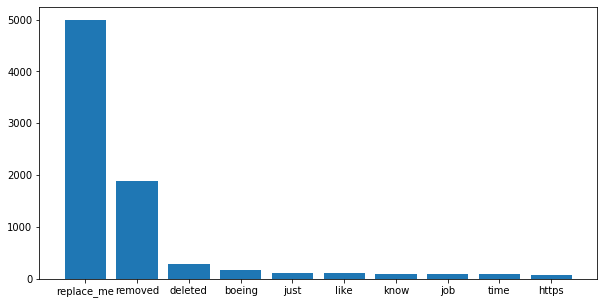

In [11]:
# get count of top-occurring words
top_words_tf = {}
for i in nums_df.columns:
    top_words_tf[i] =  nums_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_tf = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

plt.figure(figsize = (10, 5))

# visualize top 10 words
plt.bar(most_freq_tf[0][:10], most_freq_tf[1][:10]);

We can see that if we remove 'replace_me', 'removed', and 'deleted', then we'll be dealing with a much more useful dataset.  For the words dataframe, we can just add these words to our stop_words library.  For the numeric dataframe we'll drop them here, as well as a few more.

In [12]:
dropwords = ['replace_me', 'removed', 'deleted', 'https', 'com', 'don', 'www']
nums_df = nums_df.drop(columns=dropwords)

And we can re-run the graph above for a better look.

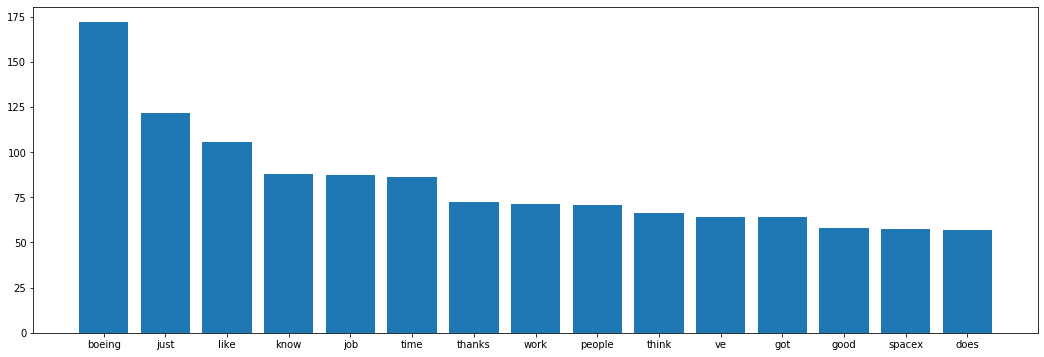

In [13]:
# get count of top-occurring words
top_words_tf = {}
for i in nums_df.columns:
    top_words_tf[i] =  nums_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_tf = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

plt.figure(figsize = (18, 6))
dude.graph_words('black')

# visualize top 10 words
plt.bar(most_freq_tf[0][:15], most_freq_tf[1][:15]);

If I had more time I'd like to graph the words used most in each company.  I can go ahead and try to display which company is more verbose, wordy that is, and which one uses longer words (Credit to Hovanes Gasparian).

In [14]:
nums_df = pd.concat([space_wars['subreddit'], nums_df])

In [15]:
space_wars['word_count'] = space_wars['body'].apply(dude.word_count)
space_wars['post_length'] = space_wars['body'].apply(dude.count_chars)

In [16]:
space_wars[['word_count', 'post_length']].describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,13787.0,23.880322,58.940570,1.0,1.0,1.0,25.0,1620.0
post_length,13787.0,144.042214,396.730953,1.0,10.0,10.0,144.0,12831.0


In [17]:
space_wars.groupby(['word_count']).size().sort_values(ascending=False)#.head()


word_count
1       7310
10       169
6        164
7        163
5        155
        ... 
285        1
281        1
280        1
277        1
1620       1
Length: 337, dtype: int64

In [18]:
space_wars[space_wars['word_count'] > 1000]

,subreddit,body,permalink,word_count,post_length
69,1,[](/# MC // section intro)\n# Welcome to the r...,/r/spacex/comments/hu6sci/rspacex_anasisii_off...,1072,7142
477,1,#### Quick Links[](https://www.spacex.com/site...,/r/spacex/comments/hf368o/starship_development...,1158,12831
728,1,[](https://pbs.twimg.com/media/D7TjU7DXkAAqtVZ...,/r/spacex/comments/h8mold/starlink9_launch_cam...,1097,9267
1996,1,[](/# MC // section intro)\n# Welcome to the r...,/r/spacex/comments/gkfe30/rspacex_starlink_7_o...,1226,9959
2707,1,[](https://pbs.twimg.com/media/D7TjU7DXkAAqtVZ...,/r/spacex/comments/fxkc7k/starlink6_launch_cam...,1006,8358
4587,1,JCSAT-18/Kacific1 Launch Infographic by [Geoff...,/r/spacex/comments/e5w3n3/jcsat18kacific1_laun...,1319,9128
885,0,**A Time For Recusal: U.S. Judge Presiding Ov...,/r/boeing/comments/eiq7gy/737max_lawsuits_shou...,1620,10461
1763,0,"Why did that Boeing crash? Trust me, Boeing is...",/r/boeing/comments/b9znku/why_did_that_boeing_...,1197,7731
1972,0,Why did that Boeing crash? Yet again we don't ...,/r/boeing/comments/azh5fw/why_did_that_boeing_...,1207,8033


In [19]:
#space_wars.groupby(['subreddit', 'word_count']).size().sort_values(ascending=False).head()
space_wars.subreddit.value_counts()

1    7963
0    5824
Name: subreddit, dtype: int64

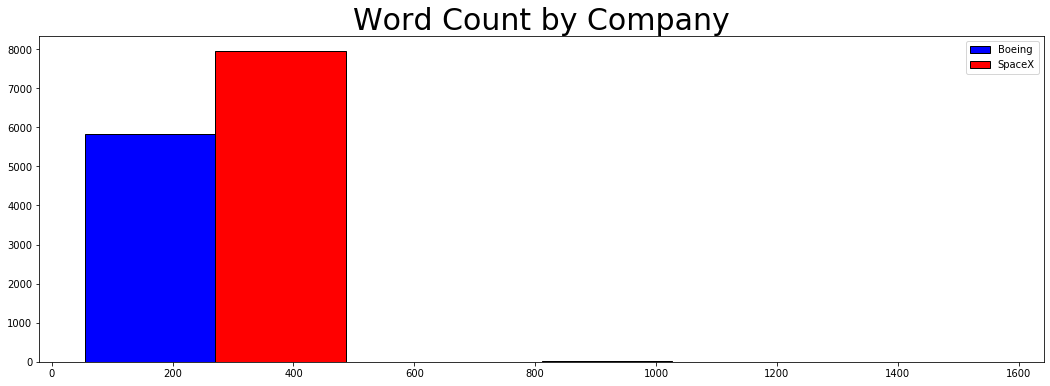

In [29]:
plt.figure(figsize=(18,6))
dude.graph_words('black')
plt.hist([space_wars[space_wars['subreddit']==0]['word_count'], 
          space_wars[space_wars['subreddit']==1]['word_count']],
         bins=3, color=['blue', 'red'], ec='k')
plt.title('Word Count by Company', fontsize=30)
plt.legend(['Boeing', 'SpaceX']);

## Trouble in parsing-dise
It appears that I'm having some issues with manipulating this portion of the data. I will clean this up before final pull request.

## Create test_train_split with word data

#### Find the baseline:

In [65]:
baseline = space_wars.subreddit.value_counts(normalize=True)[1]
all_scores = {}
all_scores['baseline'] = baseline
all_scores['baseline']

0.5775730760861681

In [37]:
X_words = space_wars['body']
y_words = space_wars['subreddit']

In [32]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_words,
                                                           y_words,
                                                           random_state=42,
                                                           test_size=.1,
                                                           stratify=y_words)

## Now it's time to train some models!

In [39]:
# Modify our stopwords list from the nltk.'english'
stopwords = nltk.corpus.stopwords.words('english')
# Above we created a list called dropwords
for i in dropwords:
    stopwords.append(i)

In [40]:
param_cv = {
    'stop_words' : stopwords,
    'ngram_range' : (1, 2),
    'analyzer' : 'word',
    'max_df' : 0.8,
    'min_df' : 0.02,
}

In [41]:
cntv = CountVectorizer(param_cv)

In [44]:
# Print y_test for a sanity check
y_test_w

132     1
2553    1
3548    1
4917    0
871     0
       ..
2136    1
36      1
1871    0
5466    0
5116    0
Name: subreddit, Length: 1379, dtype: int64

In [45]:
# credit Noelle from lecture
train_data_features = cntv.fit_transform(X_train_w, y_train_w)
test_data_features = cntv.transform(X_test_w)

## Logistic Regression

In [49]:
lr = LogisticRegression( max_iter = 10_000)

lr.fit(train_data_features, y_train_w)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
lr.score(train_data_features, y_train_w)

0.8382495164410058

In [84]:
all_scores['Logistic Regression'] = lr.score(test_data_features, y_test_w)
all_scores['Logistic Regression']

0.7991298042059464

***Using a simple Logistic regression with very little tweaking, a set of stopwords, we created a model that while slightly overfit, is more than 22 points more accurate than the baseline.***

## What does the confusion matrix look like?  Is 80% accuracy even good?

Perhaps I can get some help making a confusion matrix with this data?

## Multinomial Naive Bayes using CountVectorizer

In this section we will create a Pipeline that starts with the CountVectorizer and ends with the Multinomial Naive Bayes Algorithm.  We'll run through 270 possible configurations of this model, and run it in parallel on 3 of the 4 cores on my machine.

In [52]:
pipe = Pipeline([
    ('count_v', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'count_v__max_features': [2000, 5000, 9000],
    'count_v__stop_words': [stopwords],
    'count_v__min_df': [2, 3, 10],
    'count_v__max_df': [.9, .8, .7],
    'count_v__ngram_range': [(1, 1), (1, 2)]
}

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5,
                  n_jobs=6
)

In [53]:
%%time
gs.fit(X_train_w, y_train_w)

Wall time: 53 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('count_v',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

In [54]:
gs.best_params_

{'count_v__max_df': 0.9,
 'count_v__max_features': 9000,
 'count_v__min_df': 2,
 'count_v__ngram_range': (1, 1),
 'count_v__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'abo

In [66]:
all_scores['Naive Bayes'] = gs.best_score_
all_scores['Naive Bayes']

0.7967436644201004

In [59]:
gs.best_index_
# is this the index that has the best indication of being positive?

12

We see that our Naive Bayes model yields an accuracy score just shy of our Logistic Regression model, 79.7%

**What does the confusion matrix look like?**

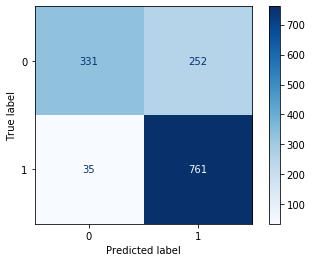

In [72]:
# Get predictions and true/false pos/neg
preds = gs.predict(X_test_w)
tn, fp, fn, tp = confusion_matrix(y_test_w, preds).ravel()

# View confusion matrix
dude.graph_words('black')
plot_confusion_matrix(gs, X_test_w, y_test_w, cmap='Blues', values_format='d');

In [74]:
sensitivity = tp / (tp + fp)
sensitivity

0.7512339585389931

In [75]:
specificity = tn / (tn + fn)
specificity

0.9043715846994536

## Naive Bayes using the TFID Vectorizer

In [77]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params_tvec = {
    'tvec__max_features': [2000, 9000],
    'tvec__stop_words' : [None, stopwords],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

gs_tvec = GridSearchCV(pipe_tvec, pipe_params_tvec, cv = 5)

In [78]:
%%time
gs_tvec.fit(X_train_w, y_train_w)

Wall time: 37.1 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [82]:
all_scores['Naive Bayes TFID'] = gs_tvec.best_score_
all_scores['Naive Bayes TFID']

0.7958569901598646

In [85]:
all_scores

{'baseline': 0.5775730760861681,
 'Naive Bayes': 0.7967436644201004,
 'Naive Bayes TFID': 0.7958569901598646,
 'Logistic Regression': 0.7991298042059464}

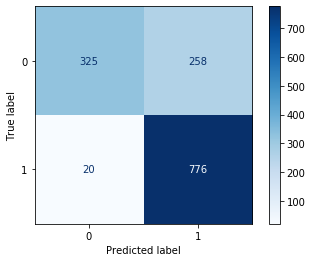

In [110]:
# Confusion Matrix for tvec
preds = gs_tvec.predict(X_test_w)
tn, fp, fn, tp = confusion_matrix(y_test_w, preds).ravel()
# View confusion matrix
dude.graph_words('black')
plot_confusion_matrix(gs_tvec, X_test_w, y_test_w, cmap='Blues', values_format='d');

In [87]:
specificity = tn / (tn+fn)
specificity

0.9420289855072463

In [88]:
sensitivity = tp / (tp+fp)
sensitivity

0.7504835589941973

Here, the specificity is 4 points higher than the NB using Count Vectorizer, but the sensitity and overall accuracy are about the same.

## Random Cut Forest and Extra Trees

In [90]:
pipe_rf = Pipeline([
    ('count_v', CountVectorizer()),
    ('rf', RandomForestClassifier()),
])

pipe_ef = Pipeline([
    ('count_v', CountVectorizer()),
    ('ef', ExtraTreesClassifier()),
])

pipe_params = {
    'count_v__max_features': [2000, 5000, 9000],
    'count_v__stop_words': [stopwords],
    'count_v__min_df': [2, 3, 10],
    'count_v__max_df': [.9, .8, .7],
    'count_v__ngram_range': [(1, 1), (1, 2)]
}

In [92]:
%%time
gs_rf = GridSearchCV(pipe_rf,
                  pipe_params,
                  cv = 5,
                  n_jobs=6)
gs_rf.fit(X_train_w, y_train_w)
print(gs_rf.best_score_)
gs_rf.best_params_

0.7736946482225429
Wall time: 5min 47s


{'count_v__max_df': 0.7,
 'count_v__max_features': 9000,
 'count_v__min_df': 2,
 'count_v__ngram_range': (1, 1),
 'count_v__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'abo

In [93]:
gs_rf.best_estimator_

Pipeline(memory=None,
         steps=[('count_v',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.7,
                                 max_features=9000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'l...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
 

In [94]:
all_scores['Random Cut Forest'] = gs_rf.best_score_
all_scores

{'baseline': 0.5775730760861681,
 'Naive Bayes': 0.7967436644201004,
 'Naive Bayes TFID': 0.7958569901598646,
 'Logistic Regression': 0.7991298042059464,
 'Random Cut Forest': 0.7736946482225429}

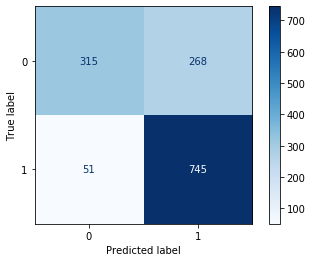

In [115]:
# Confusion Matrix for Random Cut Forest
preds = gs_rf.predict(X_test_w)
tn, fp, fn, tp = confusion_matrix(y_test_w, preds).ravel()
# View confusion matrix
dude.graph_words('black')
plot_confusion_matrix(gs_rf, X_test_w, y_test_w, cmap='Blues', values_format='d');

In [112]:
specificity = tn / (tn+fn)
specificity

0.860655737704918

In [113]:
sensitivity = tp / (tp+fp)
sensitivity

0.7354392892398816

Our original Logistic Regression model is still the winner.

## What does the matchup look like?

In [119]:
score_df = pd.DataFrame([all_scores])
score_df.shape

(1, 5)

In [120]:
score_df.head()

,baseline,Naive Bayes,Naive Bayes TFID,Logistic Regression,Random Cut Forest
0,0.577573,0.796744,0.795857,0.79913,0.773695


## Create a Count Vecotorized dataset
Since the below cells have been troublesome, we'll create a dataset using only the count vectorizer and then use that data in the model as we did above.

In [122]:
# Re-establish the subsets using Noelle's starter script again
train_data_features = cntv.fit_transform(X_train_w, y_train_w)
test_data_features = cntv.transform(X_test_w)

In [125]:
pipe_params_tvec = {
    'tvec__max_features': [2000, 9000],
    'tvec__stop_words' : [None, stopwords],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

tree_pipe = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('tree', DecisionTreeClassifier())
])

ada_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
])

grad_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('grad_boost', GradientBoostingClassifier()),
])

### Irreconcilable Error:

At this time there are still structural issues that are not allowing this last block of code to complete the final model attempts (user error).

***In the next few days, prior to publication, this notebook will be revamped and this final cell will execute.***

In [127]:
%%time

vote = VotingClassifier([
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ('grad_boost', GradientBoostingClassifier()),
    ('tree', DecisionTreeClassifier()),
    ('knn_pipe', knn_pipe)
])
params = {
    'ada__n_estimators': [50, 51],    # since HPO names are common, use dunder from tuple names
    'grad_boost__n_estimators': [10, 11],
    'knn_pipe__knn__n_neighbors': [3, 5],
    'ada__base_estimator__max_depth': [1, 2],
    'tree__max_depth': [1, 2],
    'weights':[[.25] * 4, [.3, .3, .3, .1]]
}

gs = GridSearchCV(vote, param_grid=params, cv=3)
gs.fit(train_data_features, y_train_w)
print(gs.best_score_)
gs.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Cannot center sparse matrices: pass `with_mean=Fals

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.